In [15]:
import pandas as pd
import numpy as np

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth',200)

In [16]:
# !curl -L -o ./data/cardataset.zip https://www.kaggle.com/api/v1/datasets/download/CooperUnion/cardataset | unzip ./data/cardataset.zip -d ./data/cardataset

Data Preparation

In [17]:
rawData = pd.read_csv('./data/cardataset/data.csv')
print(rawData.head())

  Make       Model  Year             Engine Fuel Type  Engine HP  Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors                        Market Category Vehicle Size Vehicle Style  highway MPG  city mpg  Popularity   MSRP
0  BMW  1 Series M  2011  premium unleaded (required)      335.0               6.0            MANUAL  rear wheel drive              2.0  Factory Tuner,Luxury,High-Performance      Compact         Coupe           26        19        3916  46135
1  BMW    1 Series  2011  premium unleaded (required)      300.0               6.0            MANUAL  rear wheel drive              2.0                     Luxury,Performance      Compact   Convertible           28        19        3916  40650
2  BMW    1 Series  2011  premium unleaded (required)      300.0               6.0            MANUAL  rear wheel drive              2.0                Luxury,High-Performance      Compact         Coupe           28        20        3916  36350
3  BMW    1 Series  2011

In [18]:
# Create copy of the read data
df = rawData.copy() 
# The column names have case, space and special character ('_') issues - make them uniform
df.columns = df.columns.str.lower().str.replace(pat=r' ', repl='_')

In [19]:
catCols = df.select_dtypes(include=['O']).columns.to_list()
df[catCols] = df[catCols].replace(regex={r' ':'_'}).map(lambda x: x.lower() if isinstance(x, str) else x)
# Other approach: df[df.dtypes[df.dtypes=='object'].index.to_list()].map(lambda x: x.lower().replace(' ','_') if isinstance(x, str) else x)

EDA

In [20]:
# Get unique values (for category attrs), missing values, and data type for the columns
def getCatSummary(df, catCols):
    dataTypes = df[catCols].dtypes
    missingValues = df[catCols].isnull().sum()
    levels = df[catCols].apply(lambda x: x.nunique())
    levelsVals = df[catCols].apply(lambda x: x.unique()[:5])
    # levels = pd.concat([levels, pd.Series(np.zeros(len(numCols),dtype=int),index=numCols)],axis=0)
    # levelsVals = pd.concat([levelsVals, pd.Series(np.zeros(len(numCols),dtype=int),index=numCols)],axis=0)
    return pd.concat([dataTypes, missingValues, levels, levelsVals],axis=1,keys=['dataTypes','missingvalues','levels','levelsValues']) # join dataframes using indices - pd.merge() for joining using indices or columns

def getNumSummary(df, numCols):
    dataTypes = df[numCols].dtypes
    missingValues = df[numCols].isnull().sum()
    levels = df[numCols].apply(lambda x: x.nunique())
    levelsVals = df[numCols].apply(lambda x: x.unique()[:5])
    descriptiveStats = df[numCols].describe(percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]).transpose()
    return pd.concat([dataTypes, missingValues, levels, levelsVals, descriptiveStats],axis=1,keys=['dataTypes','missingvalues','levels','levelsVals'] + descriptiveStats.columns.to_list())

In [21]:
numCols = list(set(df.columns) - (set(catCols)))
print(getCatSummary(df, catCols))
print('*'*20)
print(getNumSummary(df, numCols))

                  dataTypes  missingvalues  levels                                                                                                       levelsValues
make                 object              0      48                                                                         [bmw, audi, fiat, mercedes-benz, chrysler]
model                object              0     914                                                                 [1_series_m, 1_series, 100, 124_spider, 190-class]
engine_fuel_type     object              3      10  [premium_unleaded_(required), regular_unleaded, premium_unleaded_(recommended), flex-fuel_(unleaded/e85), diesel]
transmission_type    object              0       5                                                       [manual, automatic, automated_manual, direct_drive, unknown]
driven_wheels        object              0       4                                           [rear_wheel_drive, front_wheel_drive, all_wheel_drive, four_wheel_drive]
mark

/tmp/ipykernel_9709/1567474202.py:17: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  return pd.concat([dataTypes, missingValues, levels, levelsVals, descriptiveStats],axis=1,keys=['dataTypes','missingvalues','levels','levelsVals'] + descriptiveStats.columns.to_list())


Plot Distribution

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

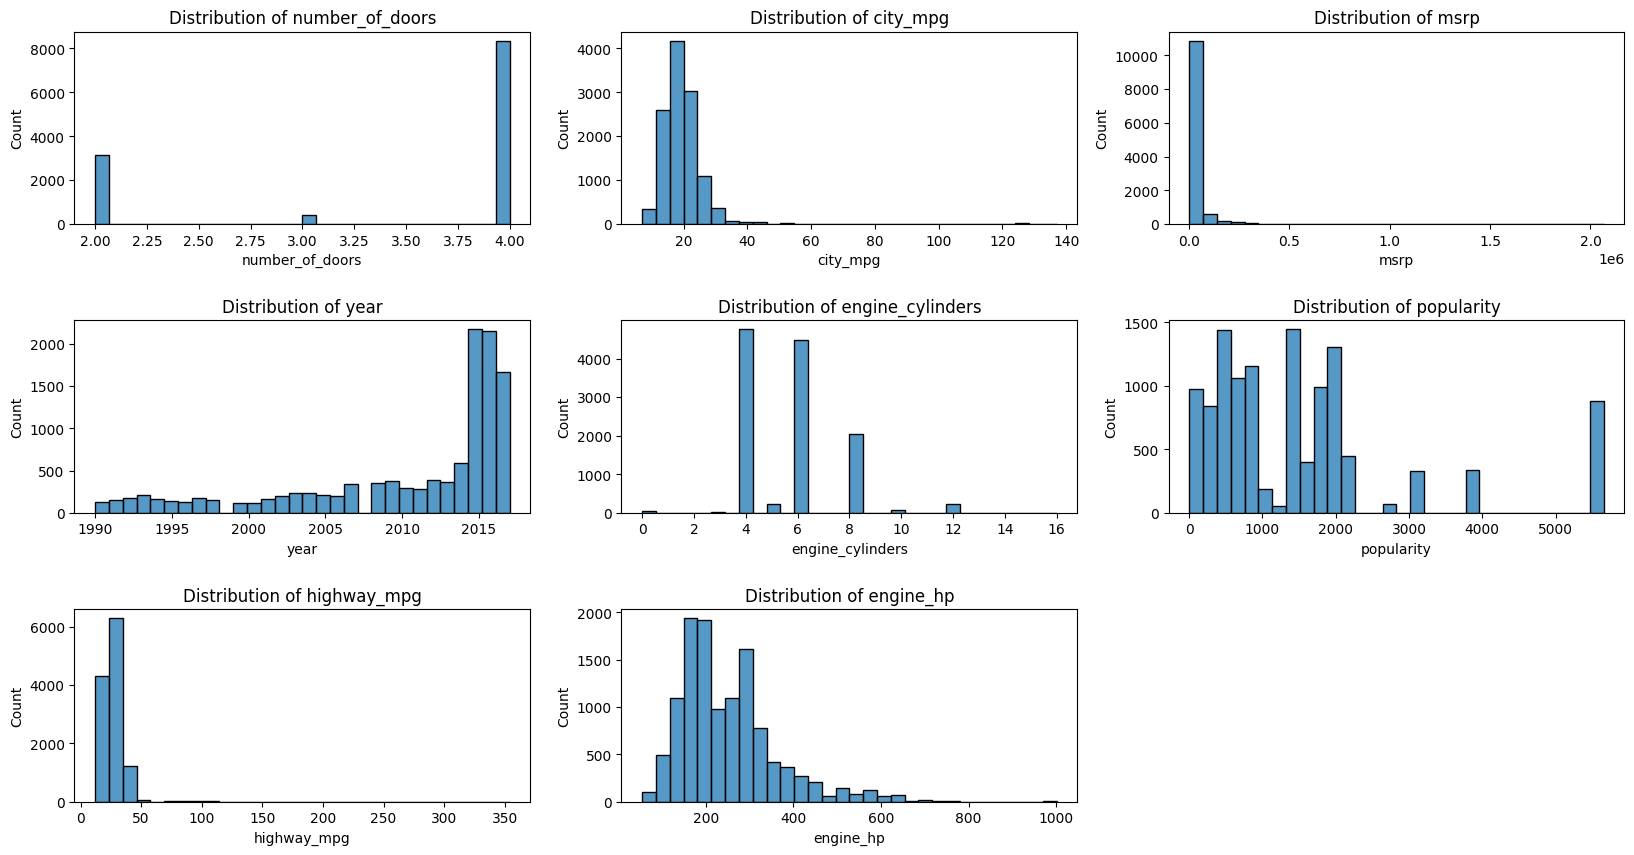

In [23]:
# Distribution of numerical variables
cols = 3
rows = int(np.ceil(len(numCols)/cols))
itr_rows = 0
itr_cols = 0

fig, ax = plt.subplots(rows, cols, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5)
for i in range(len(numCols)):
    if (itr_cols == cols):
        itr_rows += 1
        itr_cols = 0
    sns.histplot(ax=ax[itr_rows, itr_cols], x=df[numCols[i]], bins=30)
    ax[itr_rows, itr_cols].set_title('Distribution of ' + numCols[i])
    itr_cols += 1

    if (i >= len(numCols)-1):
        ax[itr_rows, itr_cols].axis('off')

Text(0.5, 0, 'log1p(msrp)')

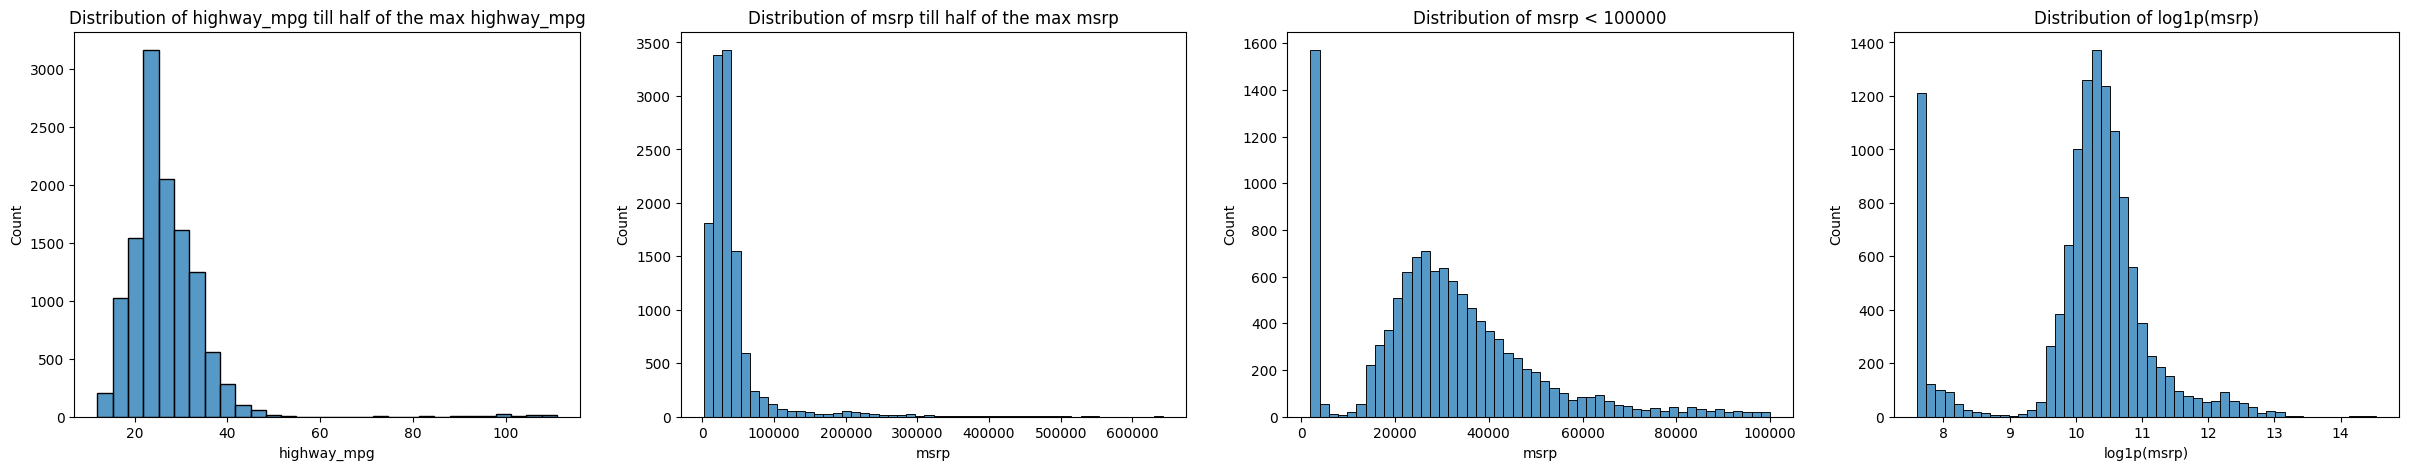

In [24]:
fig, ax = plt.subplots(1,4,figsize = (30,5))

sns.histplot(ax=ax[0], x=df.loc[df['highway_mpg'] < 0.5*(max(df['highway_mpg'])),'highway_mpg'], bins=30)
ax[0].set_title('Distribution of highway_mpg till half of the max highway_mpg')

sns.histplot(ax=ax[1], x=df.loc[df['msrp'] < 0.5*(max(df['msrp'])),'msrp'], bins=50)
ax[1].set_title('Distribution of msrp till half of the max msrp')

sns.histplot(ax=ax[2], x=df.loc[df['msrp'] < 100000,'msrp'], bins=50)
ax[2].set_title('Distribution of msrp < 100000')

# log transformation brings a highly skewed distribution to a normal range - log(10) = 1, log(10000) = 4 etc. log1p() avoids the log(0) error by adding 1 to each value before taking the log
sns.histplot(ax=ax[3], x=np.log1p(df['msrp']), bins=50)
ax[3].set_title('Distribution of log1p(msrp)')
ax[3].set_xlabel('log1p(msrp)')

Text(0.5, 0, 'log1p(msrp)')

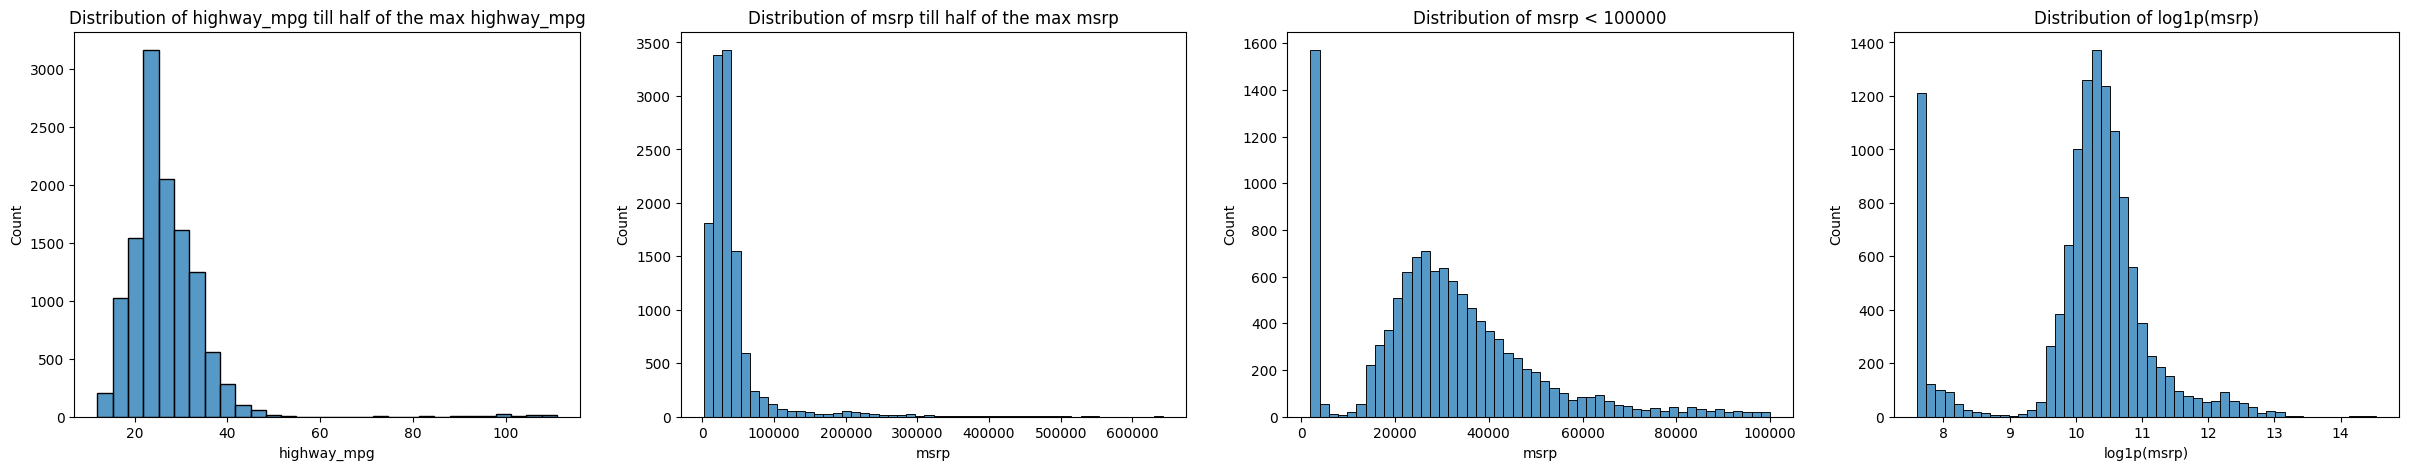

In [25]:
fig, ax = plt.subplots(1,4,figsize = (30,5))

sns.histplot(ax=ax[0], x=df.loc[df['highway_mpg'] < 0.5*(max(df['highway_mpg'])),'highway_mpg'], bins=30)
ax[0].set_title('Distribution of highway_mpg till half of the max highway_mpg')

sns.histplot(ax=ax[1], x=df.loc[df['msrp'] < 0.5*(max(df['msrp'])),'msrp'], bins=50)
ax[1].set_title('Distribution of msrp till half of the max msrp')

sns.histplot(ax=ax[2], x=df.loc[df['msrp'] < 100000,'msrp'], bins=50)
ax[2].set_title('Distribution of msrp < 100000')

# log transformation brings a highly skewed distribution to a normal range - log(10) = 1, log(10000) = 4 etc. log1p() avoids the log(0) error by adding 1 to each value before taking the log
sns.histplot(ax=ax[3], x=np.log1p(df['msrp']), bins=50)
ax[3].set_title('Distribution of log1p(msrp)')
ax[3].set_xlabel('log1p(msrp)')

Observations:
1. Though we would use engine_cylinders, year, number_of_doors as numerical variables, the analysis w.r.t the msrp should be done by treating them as discrete numerical variables.
2. highway_mpg, city_mpg, engine_hp, popularity msrp show a long-tail distribution due to presence of a few large values. We see that by limiting the values for these features. We would want to either put a cap on the values, or perform some transformation such as log which will bring the values within a desirable range.
3. There is a large number of observations for which we have 2000 as msrp. This might be the min value or the default value a seller can enter


Train-Validation-Test Split

In [26]:
# Shuffle the indices
np.random.seed(2)
rows_idx = np.arange(df.shape[0])
np.random.shuffle(rows_idx)

# Train:Validation:Test - 60:20:20; Find the number of rows in each dataset
rows_valid = int(np.floor(len(rows_idx)*0.2))
rows_test = rows_valid
rows_train = df.shape[0] - rows_valid - rows_test

# 0 - 7149, 7150 - 9531, 9532 - 2382
df_train = df.iloc[:rows_train,:]
df_valid = df.iloc[rows_train:rows_train+rows_valid,:]
df_test = df.iloc[rows_train+rows_valid:,:]

# Reset indices
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Feature Transformation

In [27]:
# Transform the msrp feature to the log scale
y_train = np.log1p(df_train.msrp.values)
y_valid = np.log1p(df_valid.msrp.values)
y_test = np.log1p(df_test.msrp.values)

df_train = df_train.drop('msrp',axis=1)
df_valid = df_valid.drop('msrp',axis=1)
df_test = df_test.drop('msrp',axis=1)

In [40]:
# Linear Regression - One sample
def g(xi):
    pred = w0
    pred += sum(np.multiply(xi, wi))
    return pred

xi = [453, 11, 86]
w0 = 7.17
wi = [0.01, 0.04, 0.002]

# Since we transformed the target variable, we will get the log-transformed g(xi) - to convert it back to xi, we take exponent of it
log_gxi = g(xi)
# We had added 1 to each value to prevent log(0). Hence, we substract -1 from np.exp(log_gxi) - similar thing is done by np.expm1()
gxi = np.expm1(log_gxi) 
print(gxi)

222347.22211010658
